In [ ]:
! python "%INTEL_OPENVINO_DIR%\deployment_tools\tools\model_downloader\downloader.py" \
  --name googlenet-v1,mobilenet-ssd
! python "%INTEL_OPENVINO_DIR%\deployment_tools\tools\model_downloader\converter.py" \
  --name googlenet-v1,mobilenet-ssd \
  --precisions FP16
! copy "%INTEL_OPENVINO_DIR%\deployment_tools\demo\car.png" .
! copy "%INTEL_OPENVINO_DIR%\deployment_tools\demo\car_1.bmp" .
! copy "%INTEL_OPENVINO_DIR%\deployment_tools\open_model_zoo\demos\python_demos\instance_segmentation_demo\coco_labels.txt" .


In [1]:
from openvino.inference_engine import IECore, IENetwork, ExecutableNetwork

In [26]:
# Heatmap visualize utility functions
#
%matplotlib inline

from math import exp

import numpy as np
from numpy.lib.stride_tricks import as_strided

import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.filters import maximum_filter

def load_IR_model(model):
    ie = IECore()
    net = ie.read_network(model+'.xml', model+'.bin')
    exenet = ie.load_network(net, 'CPU')
    inblobs =  (list(net.inputs.keys()))
    outblobs = (list(net.outputs.keys()))
    inshapes  = [ net.inputs [i].shape for i in inblobs  ]
    outshapes = [ net.outputs[i].shape for i in outblobs ]
    print('Input blobs: ', inblobs, inshapes)
    print('Output blobs:', outblobs, outshapes)
    return ie, net, exenet, inblobs, outblobs, inshapes, outshapes

def infer_ocv_image(exenet, inblob_name, image):
    net=exenet.get_exec_graph_info()      # Obtain IENetwork
    inblob  = list(net.inputs.keys())[0]  # Obtain the name of the 1st input blob
    inshape = net.inputs[inblob].shape
    
    img = cv2.resize(image, (inshape[-1], inshape[-2]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.transpose((2,0,1))          # HWC -> CHW, packed pixel -> planar
    res = exenet.infer(inputs={inblob_name:img})
    return res
    
def read_label_text_file(file):
    try:
        label = open(file).readlines()
    except OSError as e:
        label = []
    return label

#--------------------------------------------------------------------

def softmax(x):
    u = np.sum(np.exp(x))
    return np.exp(x)/u

def max_pooling_2d(A, kernel_size, stride=1, padding=1):
    """
    Inputs:
      A: HW array
    """
    A = np.pad(A, padding, mode='constant')
    output_shape = ((A.shape[0] - kernel_size)//stride + 1,
                    (A.shape[1] - kernel_size)//stride + 1)
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(A, shape=output_shape + kernel_size, strides=(stride*A.strides[0], stride*A.strides[1]) + A.strides)
    A_w = A_w.reshape(-1, *kernel_size)

    return A_w.max(axis=(1, 2)).reshape(output_shape)

def index_sort(nparray, reverse=False):
    """
    Inputs:
      reverse: Sort order, True=Large->Small, False=Small->Large
    Return:
      idx: List of index to the original array
    """
    idx = np.argsort(nparray)
    if reverse:
        return idx[::-1]
    else:
        return idx

#--------------------------------------------------------------------

def bbox_IOU(bbox1, bbox2):
    _xmin, _ymin, _xmax, _ymax = 3, 4, 5, 6
    width_of_overlap_area  = min(bbox1[_xmax], bbox2[_xmax]) - max(bbox1[_xmin], bbox2[_xmin])
    height_of_overlap_area = min(bbox1[_ymax], bbox2[_ymax]) - max(bbox1[_ymin], bbox2[_ymin])
    if width_of_overlap_area < 0 or height_of_overlap_area < 0:
        area_of_overlap = 0
    else:
        area_of_overlap = width_of_overlap_area * height_of_overlap_area
    bbox1_area = (bbox1[_ymax] - bbox1[_ymin]) * (bbox1[_xmax] - bbox1[_xmin])
    bbox2_area = (bbox2[_ymax] - bbox2[_ymin]) * (bbox2[_xmax] - bbox2[_xmin])
    area_of_union = bbox1_area + bbox2_area - area_of_overlap
    if area_of_union == 0:
        return 0
    return area_of_overlap / area_of_union

def bbox_NMS(bboxes, threshold=0.7):
    _clsid, _prob = 1, 2
    bboxes = sorted(bboxes, key=lambda x: x[_prob], reverse=True)
    for i in range(len(bboxes)):
        if bboxes[i][_prob] == -1:
            continue
        for j in range(i + 1, len(bboxes)):
            if bbox_IOU(bboxes[i], bboxes[j]) > threshold:
                bboxes[j][_prob] = -1

def detect_peaks(hm, filter_size=3, order=0.5):
    """
    Inputs:
     hm: HW
    """
    local_max = maximum_filter(hm, footprint=np.ones((filter_size, filter_size)), mode='constant')
    detected_peaks = np.ma.array(hm, mask=~(hm == local_max))
    
    temp = np.ma.array(detected_peaks, mask=~(detected_peaks >= detected_peaks.max() * order))
    peaks_index = np.where((temp.mask != True))
    return peaks_index

def detect_peaks2(hm, threshold=1.):
    """
    Inputs:
     hm: HW
    """
    hm_pool = max_pooling_2d(hm, 3, 1, 1)
    interest_points = ((hm==hm_pool) * hm)             # screen out low-conf pixels
    flat            = interest_points.ravel()          # flatten
    indices         = np.argsort(flat)[::-1]           # index sort
    scores          = np.array([ flat[idx] for idx in indices ])
    
    scores          = scores[scores>=threshold]
    indices         = indices[:len(scores)]

    hm_height, hm_width = hm.shape
    ys = indices // hm_width
    xs = indices %  hm_width
    return (xs, ys)

def hm_nms(heat, kernel_size=3):
    """
    Input:
      heat: CHW
    """
    pad = (kernel_size - 1) // 2
    hmax = np.array([max_pooling_2d(channel, kernel_size, pad) for channel in heat])
    keep = (hmax == heat)
    return heat * keep

def display_heatmap(hm, overlay_img=None, normalize=True, threshold_l=-9999, threshold_h=9999, draw_peaks=False, peak_threshold=0.7):
    """
    input:
      hm            : Heatmap in NCHW format
      overlay_img   : (optional) OpenCV image to display with the heatmap
      normalize     : True = normalize the heatmap (0.0-1.0)
      threahold_l, threshold_h : Low and high threshold value to mark lowlight and highlight region
      draw_peaks    : True = Draw peak points
      peak_treshold : Threshold value to detect peaks
    """
    num_channels = hm.shape[1]

    max_grid_x = 3
    
    if num_channels<max_grid_x:
        grid_x = num_channels
        grid_y = 1
    else:
        grid_x = max_grid_x
        grid_y = num_channels // max_grid_x + 1

    pos=1
    plt.figure(figsize=(10,10))
    for ch in range(num_channels):
        print(ch, end='')
        _hm = hm[0, ch, :, :]                   # _hm = (H,W)
        _hm_h , _hm_w = _hm.shape
        _hm = _hm.reshape((_hm_h, _hm_w, 1))    # HWC

        print(' Raw : min={:.3}, max={:.3}, mean={:.3}'.format(_hm.min(), _hm.max(), _hm.mean()), end='')

        # normalize
        if normalize == True:
            _hm = (_hm-_hm.min())/(_hm.max()-_hm.min())    # Normalize (0.0-1.0)
            print(', Normalized : min={:.3}, max={:.3}, mean={:.3}'.format(_hm.min(), _hm.max(), _hm.mean()), end='')

        print()

        # Mark Highlight and lowlight
        _img = (_hm*255).astype(np.uint8)
        mask_l = np.where(_hm<threshold_l, 255, 0).astype(np.uint8)
        mask_h = np.where(_hm>threshold_h, 255, 0).astype(np.uint8)
        mask_c = cv2.bitwise_not(cv2.bitwise_or(mask_l, mask_h))
        _img   = cv2.bitwise_and(mask_c, _img)
        img_b  = cv2.bitwise_or(_img, mask_l)
        img_r  = cv2.bitwise_or(_img, mask_h)
        img_g  =                _img
        img    = cv2.merge([img_r, img_g, img_b])

        # Display the heatmap over an image (if an image is supplied)
        if not overlay_img is None:
            overlay_img = cv2.cvtColor(overlay_img, cv2.COLOR_BGR2RGB)
            overlay_img = cv2.resize(overlay_img, (img.shape[1],img.shape[0]))
            img = img//2 + overlay_img//2

        # Detect and draw peaks
        marker_color = (0,255,0)
        if draw_peaks == True:
            #peaks = detect_peaks(_hm.transpose((2,0,1)), order=peak_threshold)
            #peaks = detect_peaks(hm[:,ch,:,:], order=peak_threshold)
            peaks = detect_peaks2(_hm.reshape((_hm_h, _hm_w)), threshold=peak_threshold)
            for x, y in zip(peaks[0], peaks[1]):
                cv2.drawMarker(img, (x, y), marker_color, markerType=cv2.MARKER_TILTED_CROSS, markerSize=4, thickness=1)

        # Display the result
        plt.subplot(grid_y, grid_x, pos)
        plt.title(str(pos-1))
        plt.imshow(img)
        pos+=1

def decode_classification_result(res, top_k=5, label_file='synset_words.txt'):
    # Read class label text file
    labels = read_label_text_file(label_file)

    res = res.flatten()
    idx = index_sort(res, reverse=True)
    for i in range(top_k):
        if len(labels)==0:
            print(i+1, idx[i]+1, res[idx[i]])
        else:
            print(i+1, idx[i]+1, res[idx[i]], labels[idx[i]][:-1])

def decode_ssd_result(res, threshold=0.7):
    res = res.reshape(res.size//7, 7)         # reshape to (x, 7)
    objs = []
    for obj in res:
        imgid, clsid, confidence, x1, y1, x2, y2 = obj
        if confidence>threshold:              # Draw a bounding box and label when confidence>threshold
            objs.append([imgid, clsid, confidence, x1, y1, x2, y2])
    return objs

def draw_bboxes(objs, img, disp_label=True, label_file='voc_labels.txt'):
    # Read class label text file
    labels = read_label_text_file(label_file)

    img_h, img_w, _ = img.shape
    for obj in objs:
        imgid, clsid, confidence, x1, y1, x2, y2 = obj
        x1 = int( x1 * img_w )
        y1 = int( y1 * img_h )
        x2 = int( x2 * img_w )
        y2 = int( y2 * img_h )
        if confidence == -1:
            continue
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), thickness=2 )
        if len(labels)>0 and disp_label==True:
            cv2.putText(img, labels[int(clsid)][:-1], (x1, y1), cv2.FONT_HERSHEY_PLAIN, fontScale=4, color=(0,255,255), thickness=2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

def entry_index(side, coord, classes, location, entry):
    side_power_2 = side ** 2
    n = location // side_power_2
    loc = location % side_power_2
    return int(side_power_2 * (n * (coord + classes + 1) + entry) + loc)

def scale_bbox(x, y, h, w, class_id, confidence, h_scale, w_scale):
    xmin = int((x - w / 2) * w_scale)
    ymin = int((y - h / 2) * h_scale)
    xmax = int(xmin + w * w_scale)
    ymax = int(ymin + h * h_scale)
    return [class_id, confidence, xmin, ymin, xmax, ymax]

def parse_yolo_region(blob, resized_image_shape, params, threshold):
    param_num     = 3  if 'num'     not in params else int(params['num'])
    param_coords  = 4  if 'coords'  not in params else int(params['coords'])
    param_classes = 80 if 'classes' not in params else int(params['classes'])
    param_side    = int(params['side'])
    if 'anchors' not in params:
        anchors = [10.0, 13.0, 16.0, 30.0, 33.0, 23.0, 30.0, 61.0, 62.0, 45.0, 59.0, 119.0, 116.0, 90.0, 156.0, 198.0, 373.0, 326.0 ]
    else:
        anchors = [ float(anchor) for anchor in params['anchors'].split(',') ]
    if 'mask' not in params:
        param_anchors  = anchors
        param_isYoloV3 = False
    else:
        masks          = [ int(m) for m in params['mask'].split(',')]
        param_num      = len(masks)
        param_anchors  = [ [anchors[mask*2], anchors[mask*2+1]] for mask in masks ]
        param_isYoloV3 = True

    _, _, out_blob_h, out_blob_w = blob.shape

    resized_image_h, resized_image_w = resized_image_shape
    objects = list()
    predictions = blob.flatten()
    side_square = param_side * param_side

    for i in range(side_square):
        row = i // param_side
        col = i % param_side
        for n in range(param_num):
            obj_index = entry_index(param_side, param_coords, param_classes, n * side_square + i, param_coords)
            scale = predictions[obj_index]
            if scale < threshold:
                continue
            box_index = entry_index(param_side, param_coords, param_classes, n * side_square + i, 0)

            x = (col + predictions[box_index + 0 * side_square]) / param_side
            y = (row + predictions[box_index + 1 * side_square]) / param_side
            try:
                w_exp = exp(predictions[box_index + 2 * side_square])
                h_exp = exp(predictions[box_index + 3 * side_square])
            except OverflowError:
                continue
            w = w_exp * param_anchors[n][0] / (resized_image_w if param_isYoloV3 else param_side)
            h = h_exp * param_anchors[n][1] / (resized_image_h if param_isYoloV3 else param_side)
            for j in range(param_classes):
                class_index = entry_index(param_side, param_coords, param_classes, n * side_square + i,
                                          param_coords + 1 + j)
                confidence = scale * predictions[class_index]
                if confidence < threshold:
                    continue
                objects.append([0., j, confidence, x-w/2, y-h/2, x+w/2, y+h/2])
    return objects

def decode_yolo_result(res, net, inshapes, threshold):
    objects=[]
    for layer_name in res:
        out_blob = res[layer_name]
        params = net.layers[layer_name].params
        params['side'] = out_blob.shape[2]
        objects += parse_yolo_region(out_blob, inshapes[0][2:], params, threshold)
    return objects

    

print('Defined OpenVINO model experiment utility functions')

Defined OpenVINO model experiment utility functions


# Image Classification

In [3]:
# Load an IR model
model = 'public/googlenet-v1/FP16/googlenet-v1'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = load_IR_model(model)

Input blobs:  ['data'] [[1, 3, 224, 224]]
Output blobs: ['prob'] [[1, 1000]]


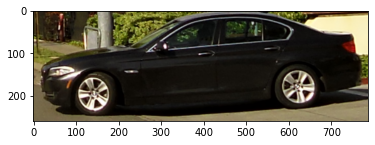

In [4]:
# Load an image and run inference
img_orig = cv2.imread('car.png')
res = infer_ocv_image(exenet, inblobs[0], img_orig)  # Inference

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [5]:
# Decode the inference result and display it
decode_classification_result(res[outblobs[0]], top_k=10, label_file='synset_words.txt')

1 480 0.5016654 car wheel
2 818 0.31316656 sports car, sport car
3 437 0.06171181 beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon
4 512 0.048884775 convertible
5 752 0.02398224 racer, race car, racing car
6 469 0.0146776335 cab, hack, taxi, taxicab
7 718 0.010849829 pickup, pickup truck
8 582 0.0068944264 grille, radiator grille
9 706 0.0022261944 passenger car, coach, carriage
10 637 0.0019383883 mailbag, postbag


# Object detection (SSD)

In [6]:
# Load an IR model
model = 'public/mobilenet-ssd/FP16/mobilenet-ssd'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = load_IR_model(model)

Input blobs:  ['data'] [[1, 3, 300, 300]]
Output blobs: ['detection_out'] [[1, 1, 100, 7]]


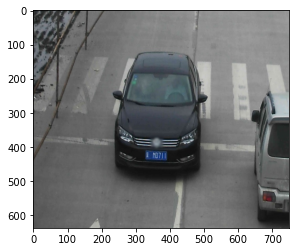

In [7]:
# Load an image and run inference
img_orig = cv2.imread('car_1.bmp')
res = infer_ocv_image(exenet, inblobs[0], img_orig)   # Inference

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [8]:
# Decode the inference result and display it
objs = decode_ssd_result(res[outblobs[0]], threshold=0.8)
print('imgid, clsid, prob, x1, y1, x2, y2')
print(objs)

imgid, clsid, prob, x1, y1, x2, y2
[[0.0, 7.0, 0.9999981, 0.30529332, 0.1880557, 0.6763692, 0.7252005], [0.0, 7.0, 0.8729512, 0.85119945, 0.3870977, 0.99222034, 0.95159996]]


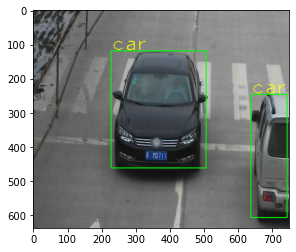

In [9]:
# Display the bbox (bounding box) on the image
draw_bboxes(objs, img_orig)

# Heatmap (DBFace)

In [10]:
# Load an IR model
model = 'dbface-vga/dbface'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = load_IR_model(model)

Input blobs:  ['x'] [[1, 3, 480, 640]]
Output blobs: ['Conv_525', 'Exp_527', 'Sigmoid_526'] [[1, 10, 120, 160], [1, 4, 120, 160], [1, 1, 120, 160]]


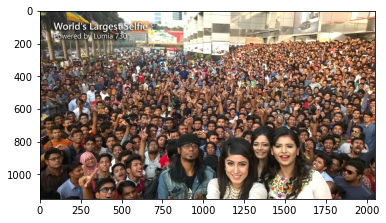

In [11]:
# Load an image and run inference
img_orig = cv2.imread('selfie.jpg')
res = infer_ocv_image(exenet, inblobs[0], img_orig)

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)

(1, 10, 120, 160)
0 Raw : min=-0.47, max=0.362, mean=-0.0378, Normalized : min=0.0, max=1.0, mean=0.519
1 Raw : min=-0.306, max=0.488, mean=0.107, Normalized : min=0.0, max=1.0, mean=0.519
2 Raw : min=-0.339, max=0.414, mean=0.0348, Normalized : min=0.0, max=1.0, mean=0.496
3 Raw : min=-0.446, max=0.278, mean=-0.0268, Normalized : min=0.0, max=1.0, mean=0.579
4 Raw : min=-0.375, max=0.482, mean=0.0802, Normalized : min=0.0, max=1.0, mean=0.531
5 Raw : min=-0.621, max=0.358, mean=-0.051, Normalized : min=0.0, max=1.0, mean=0.582
6 Raw : min=-0.641, max=0.369, mean=-0.0489, Normalized : min=0.0, max=1.0, mean=0.586
7 Raw : min=-0.446, max=0.484, mean=0.0697, Normalized : min=0.0, max=1.0, mean=0.555
8 Raw : min=-0.19, max=0.564, mean=0.189, Normalized : min=0.0, max=1.0, mean=0.502
9 Raw : min=-0.137, max=0.593, mean=0.19, Normalized : min=0.0, max=1.0, mean=0.448


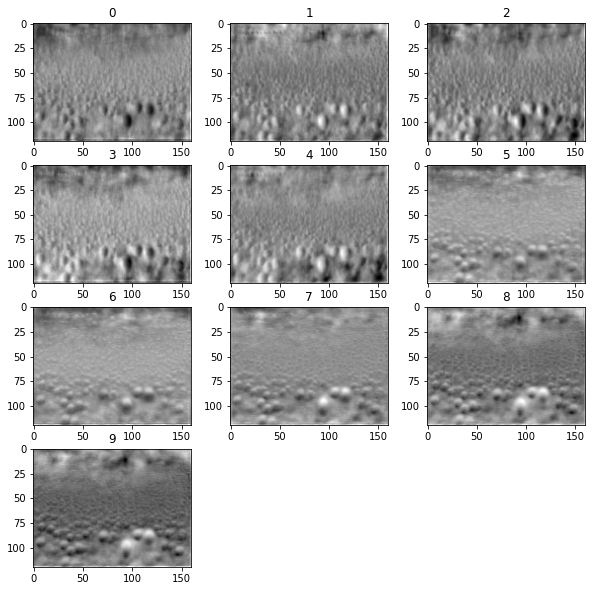

In [12]:
# Display heatmaps
hm = res[outblobs[0]]
print(hm.shape)
display_heatmap(hm)

(1, 1, 120, 160)
0 Raw : min=0.00021, max=0.765, mean=0.13, Normalized : min=0.0, max=1.0, mean=0.17
0 Raw : min=0.00021, max=0.765, mean=0.13, Normalized : min=0.0, max=1.0, mean=0.17
0 Raw : min=0.00021, max=0.765, mean=0.13, Normalized : min=0.0, max=1.0, mean=0.17


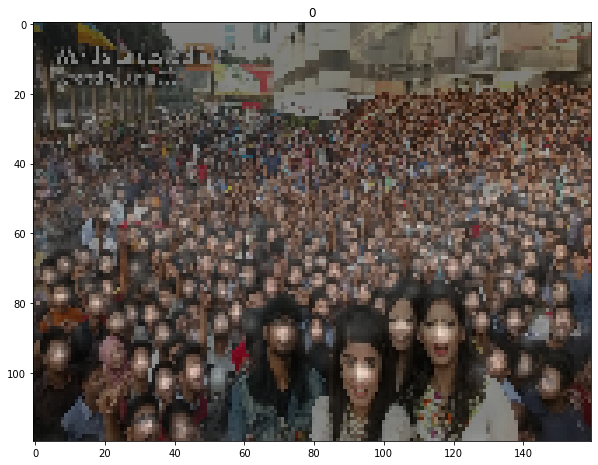

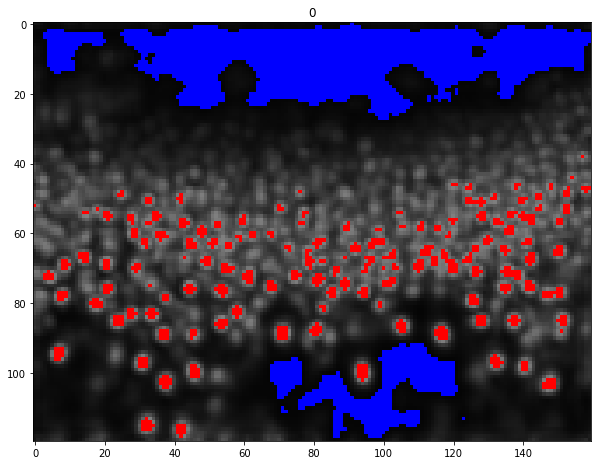

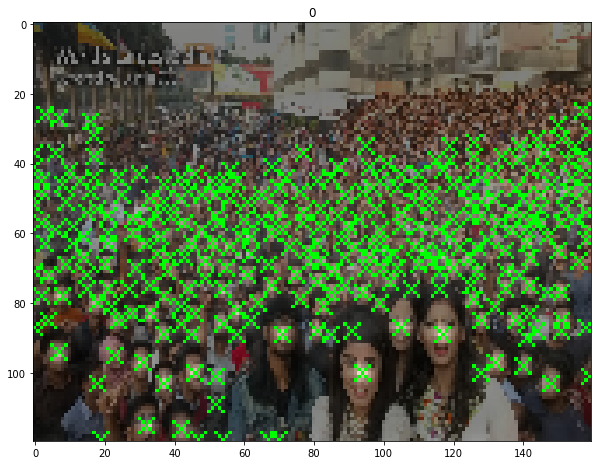

In [13]:
# Display heatmaps
hm = res[outblobs[2]]
print(hm.shape)
display_heatmap(hm, overlay_img=img_orig)

display_heatmap(hm, normalize=True, threshold_l=0.02, threshold_h=0.5)

display_heatmap(hm, overlay_img=img_orig, normalize=True, draw_peaks=True, peak_threshold=0.2)


# YOLO-v3

In [14]:
# Load an IR model
model = 'public/yolo-v3-tf/FP16/yolo-v3-tf'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = load_IR_model(model)

Input blobs:  ['input_1'] [[1, 3, 416, 416]]
Output blobs: ['conv2d_58/Conv2D/YoloRegion', 'conv2d_66/Conv2D/YoloRegion', 'conv2d_74/Conv2D/YoloRegion'] [[1, 255, 13, 13], [1, 255, 26, 26], [1, 255, 52, 52]]


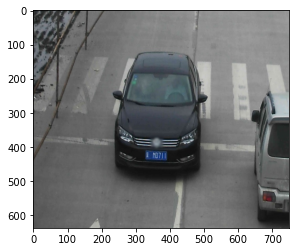

In [15]:
# Load an image and run inference
img_orig = cv2.imread('car_1.bmp')
res = infer_ocv_image(exenet, inblobs[0], img_orig)

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)

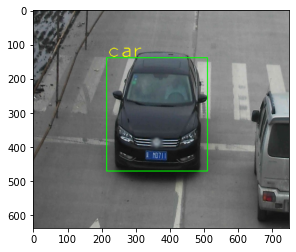

In [16]:
# Decode YOLO v3 result, run NMS to reject overlaping detections, and draw BBoxes
objects = decode_yolo_result(res, net, inshapes, threshold=0.7)
bbox_NMS(objects, threshold=0.7)

draw_bboxes(objects, img_orig, label_file='coco_labels.txt')

# CenterNet

In [17]:
# Load an IR model
model = 'public/ctdet_coco_dlav0_384/FP16/ctdet_coco_dlav0_384'
ie, net, exenet, inblobs, outblobs, inshapes, outshapes = load_IR_model(model)

Input blobs:  ['input.1'] [[1, 3, 384, 384]]
Output blobs: ['508', '511', '514'] [[1, 80, 96, 96], [1, 2, 96, 96], [1, 2, 96, 96]]


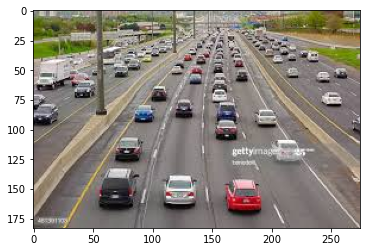

In [43]:
# Load an image and run inference
#img_orig = cv2.imread('car_1.bmp')
img_orig = cv2.imread('car1.jpg')
res = infer_ocv_image(exenet, inblobs[0], img_orig)

img = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
plt.imshow(img)

0 Raw : min=0.0, max=0.67, mean=0.00298, Normalized : min=0.0, max=1.0, mean=0.00445


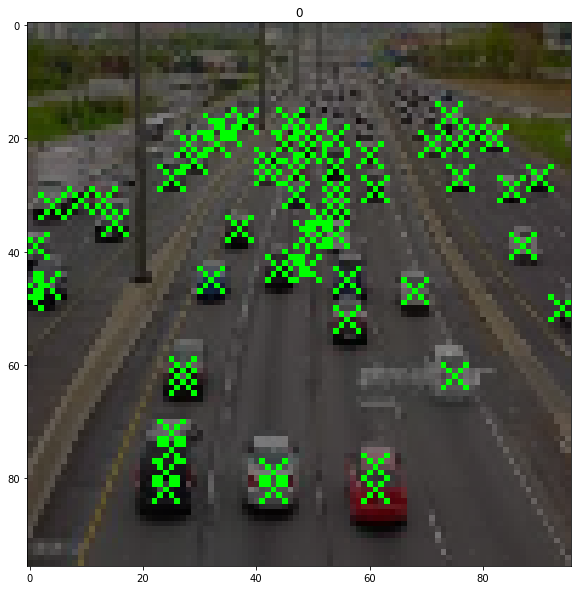

0 Raw : min=0.017, max=0.983, mean=0.5, Normalized : min=0.0, max=1.0, mean=0.5
1 Raw : min=0.0934, max=0.9, mean=0.494, Normalized : min=0.0, max=1.0, mean=0.496


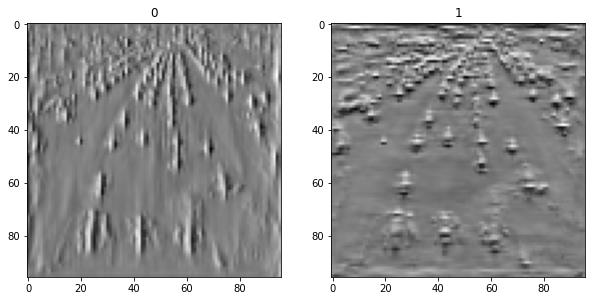

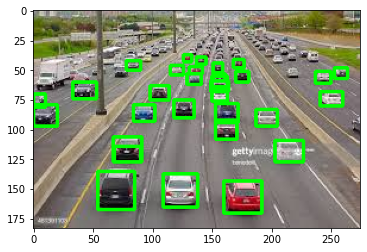

In [44]:
def decode_centernet(hm, dp1, dp2, threshold=0.7):
    """
    Inputs:
    hm: Heatmap
    dp1, dp2: Displacement map
    """
    hm = hm[0]
    hm_h, hm_w = hm.shape[-2:]
    hm = np.exp(hm)/(1 + np.exp(hm))
    objects=[]
    for ch in range(hm.shape[0]):
        if hm[ch].max()>0.5:
            peaks = detect_peaks2(hm[ch], threshold=threshold)
            for x, y in zip(peaks[0], peaks[1]):
                prob = hm[ch, y, x]
                if hm[ch, y, x]>0:
                    dx = dp1[0,0,y,x]
                    dy = dp1[0,1,y,x]
                    w  = dp2[0,0,y,x]
                    h  = dp2[0,1,y,x]
                    x1 = (x+dx-w/2)/hm_w
                    y1 = (y+dy-h/2)/hm_h
                    x2 = (x+dx+w/2)/hm_w
                    y2 = (y+dy+h/2)/hm_h
                    objects.append([0, ch, prob, x1, y1, x2, y2])
    return objects

hm = res['508'][:, 2, :, :]
hm = np.exp(hm)/(1+np.exp(hm))
#hm = softmax(hm)
hm = hm_nms(hm)
display_heatmap(hm.reshape((1,1,96,96)), overlay_img=img_orig, normalize=True, threshold_h=0.5, draw_peaks=True, peak_threshold=0.2)
plt.show()

display_heatmap(res['511'])
plt.show()

objects = decode_centernet(res['508'], res['511'], res['514'], threshold=0.3)
#print(objects, len(objects))

draw_bboxes(objects, img_orig, disp_label=False, label_file='coco_labels.txt')